# News Article Sentiment Classification

In this hands-on workshop, we'll practice classifying text on a slightly larger dataset.

Input: 8000 news articles that are labeled by relevance to the US Economy.

Task: Fit a model that classifies the articles based on whether each is relevant to the US Economy. This is a binary classification task.

Other uses of the same dataset (feel free to practice these on your owntime):
- Multi-class classification on positivity score
- Regression on relevance confidence, for the relevant articles

## Dataset

CSV: https://www.figure-eight.com/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv

Source: https://www.figure-eight.com/data-for-everyone/

Description:

>Contributors read snippets of news articles. They then noted if the article was relevant to the US economy and, if so, what the tone of the article was. Tone was judged on a 9 point scale (from 1 to 9, with 1 representing the most negativity). Dataset contains these judgments as well as the dates, source titles, and text. Dates range from 1951 to 2014.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration (20 minutes)

1. Load the data into pandas
2. Check for NaNs (if any) and decide what you would do with them

In [18]:
df = pd.read_csv('d:/tmp/news-article/Full-Economic-News-DFE-839861.csv', encoding='latin1',
                usecols=['relevance', 'text'])
df

,relevance,text
0,yes,NEW YORK -- Yields on most certificates of dep...
1,no,The Wall Street Journal Online</br></br>The Mo...
2,no,WASHINGTON -- In an effort to achieve banking ...
3,no,The statistics on the enormous costs of employ...
4,yes,NEW YORK -- Indecision marked the dollar's ton...
5,yes,"Stocks declined, as investors weighed slower-t..."
6,no,TORONTO -- Royal Bank of Canada and Bank of Mo...
7,no,Many people think that the monster of health-c...
8,no,"Sequenom Inc., a genomics-based biotechnology ..."
9,yes,The U.S. dollar declined against most major fo...


In [19]:
df.drop(df.loc[df.relevance=='not sure'].index, inplace=True)
df.relevance.unique()

array(['yes', 'no'], dtype=object)

## Data Transformation (60 minutes)

1. Convert the relevance "yes/no" into numbers using LabelEncoder
2. Perform text feature extraction on the "text" column:

   a. Use spaCy to tokenize and lemmatize.
   
   b. Pass the tokenized text into TfidfVectorizer. You can decide to train with 1-gram or 2-gram (or more if your computer is faster)

In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['y'] = encoder.fit_transform(df.relevance)
df.head()

,relevance,text,y
0,yes,NEW YORK -- Yields on most certificates of dep...,1
1,no,The Wall Street Journal Online</br></br>The Mo...,0
2,no,WASHINGTON -- In an effort to achieve banking ...,0
3,no,The statistics on the enormous costs of employ...,0
4,yes,NEW YORK -- Indecision marked the dollar's ton...,1


pd.DataFrame.apply() can be slow if run in pure python.

A way to speed things up is to compile the `tokenize_text` function in C, using Cython.

https://pandas.pydata.org/pandas-docs/stable/enhancingperf.html

```
conda install -y cython
```

Import the Cython magic function by calling `%load_ext Cython`

In [25]:
%load_ext Cython

In [28]:
%%cython

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

nlp = spacy.load('en_core_web_sm')
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

# transformation function to use in pd.DataFrame.apply()
def tokenize_text(text):
    """Tokenizes the text by lemmatizing and removing stop words
    Args:
        text - the input text
    Returns:
        a list of tokens
    """
    # process the text
    doc = nlp(text)
    
    # https://spacy.io/api/token
    lemmas = [lemmatizer(token.text, token.pos_) for token in doc
              if not token.is_stop and token.is_alpha]

    # create a string
    return ' '.join([item for sublist in lemmas for item in sublist])

In [29]:
# Test
tokenize_text(df.text[0])

'new york yield certificate deposit offer major bank drop tenth percentage point late week reflect overall decline short term interest on small denomination consumer cd sell directly bank average yield month deposit fall week end yesterday accord survey banxquote money markets wilmington information on month consumer deposit average yield sink week accord banxquote two bank banxquote survey citibank new york corestates pennsylvania pay threemonth small denomination decline somewhat small year consumer cd ease banxquote yield month month treasury bill sell monday auction plummet fifth percentage point previous week respectively'

In [30]:
# Tokenize the column (takes about 10 minutes)
# %time df_tokenized = df.text.apply(tokenize_text)
# df_tokenized.head()

Wall time: 9min 42s


0    new york yield certificate deposit offer major...
1    the wall street journal the morning brief look...
2    washington in effort achieve banking reform se...
3    the statistic enormous cost employee drug abus...
4    new york indecision mark dollar tone trader pa...
Name: text, dtype: object

In [2]:
# Save the tokenized columns to CSV, so that we don't have to tokenize again
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html

# df['tokenized'] = df_tokenized
# df.to_csv('d:/tmp/news-article/Full-Economic-News-DFE-839861.tokenized.csv', encoding='latin1',
#          index=False)

df = pd.read_csv('d:/tmp/news-article/Full-Economic-News-DFE-839861.tokenized.csv', encoding='latin1')
df.head()

,relevance,text,y,tokenized
0,yes,NEW YORK -- Yields on most certificates of dep...,1,new york yield certificate deposit offer major...
1,no,The Wall Street Journal Online</br></br>The Mo...,0,the wall street journal the morning brief look...
2,no,WASHINGTON -- In an effort to achieve banking ...,0,washington in effort achieve banking reform se...
3,no,The statistics on the enormous costs of employ...,0,the statistic enormous cost employee drug abus...
4,yes,NEW YORK -- Indecision marked the dollar's ton...,1,new york indecision mark dollar tone trader pa...


In [3]:
df_tokenized = df.tokenized
df_tokenized.head()

0    new york yield certificate deposit offer major...
1    the wall street journal the morning brief look...
2    washington in effort achieve banking reform se...
3    the statistic enormous cost employee drug abus...
4    new york indecision mark dollar tone trader pa...
Name: tokenized, dtype: object

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply the vectorizer on all tokenized rows
vectorizer = TfidfVectorizer(lowercase=False, decode_error='ignore')

# convert sparse matrix to dense matrix
X_dense = vectorizer.fit_transform(df_tokenized).todense()
print(X_dense.shape)

# print a few features
print(vectorizer.get_feature_names()[:10])

(7991, 31876)
['aa', 'aaa', 'aacer', 'aadvantage', 'aagrf', 'aairl', 'aalrl', 'aame', 'aap', 'aaron']


In [5]:
# check the distribution of the relevant / irrelevant articles
df.groupby(['y']).size()

y
0    6571
1    1420
dtype: int64

## Visualize (20 minutes)

Use `TSNE` to visualize the Tfidf vectors into a 2-D plot

Wall time: 1min 4s
(799, 2)


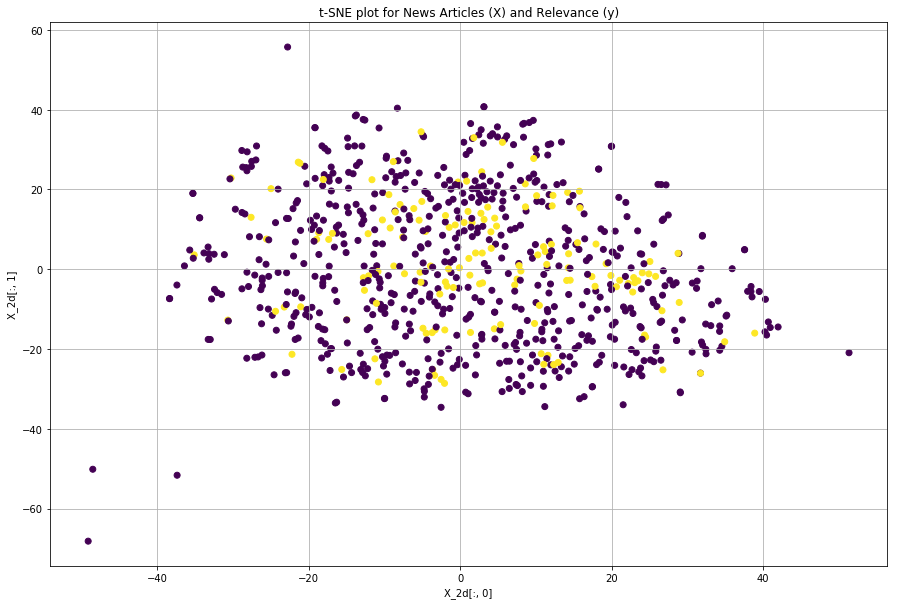

In [6]:
from sklearn.manifold import TSNE

# Sample a portion of the dataset for t-SNE (otherwise too slow)
density = 0.1

df_display = pd.DataFrame(X_dense)
df_display['y'] = df.y
sample = df_display.sample(frac=density, random_state=42)
sample_X = sample.iloc[:, :-1] # pick all but the last column ('y')

tsne = TSNE(n_components=2, random_state=42)
%time X_2d = tsne.fit_transform(sample_X)

print(X_2d.shape)

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=sample.y)

ax.set(title='t-SNE plot for News Articles (X) and Relevance (y)',
       xlabel='X_2d[:, 0]', ylabel='X_2d[:, 1]')
ax.grid()
plt.show()

In [7]:
# sample.iloc[:, :-1].columns

## Train (30 minutes)

1. Train/test split and shuffle the dataset
2. Train your favourite models with the dataset.  Keep in mind that SVM and MLPClassifier can be slow.
3. Get classification_report metric

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dense, df.y, random_state=42)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier # just for kicks
from sklearn.svm import SVC

from sklearn.metrics import classification_report

classifiers = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    #SGDClassifier(random_state=42, tol=1e-8, max_iter=1000),
    GaussianNB(),
    #SVC(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier()
    #MLPClassifier(random_state=42, tol=1e-8, max_iter=1000)
]

for clf in classifiers:
    print(type(clf))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))

<class 'sklearn.dummy.DummyClassifier'>
             precision    recall  f1-score   support

          0       0.81      0.83      0.82      1621
          1       0.18      0.17      0.18       377

avg / total       0.69      0.70      0.70      1998

<class 'sklearn.linear_model.logistic.LogisticRegression'>
             precision    recall  f1-score   support

          0       0.82      0.99      0.90      1621
          1       0.54      0.07      0.13       377

avg / total       0.77      0.81      0.75      1998

<class 'sklearn.naive_bayes.GaussianNB'>


## Predictions (30 minutes)

1. Go to reuters.com or anywhere and find any news article.
2. Get the text of the article and pass it to your best performing model.
  a. You need to first tokenize and lemmatize your test text
  b. Apply `TfidfVectorizer` to get the test input vector
  c. Run `predict` to see if your model correctly classified the text as relevant to the US Economy